In [1]:
import geopandas as gpd
from geopandas.tools import sjoin
import pandas as pd
import requests
import json
from pprint import pprint
import seaborn as sns
# from config import gkey
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
from itertools import compress

### Uploading shapefiles

The next shapefile contains the name of the quarter, the year of construction and the polygons of Benito Juarez, info available [here](https://sig.cdmx.gob.mx/datos/).

In [2]:
bj_gpd=gpd.read_file('data/shapes/BENITO_JUAREZ/BENITO_JUAREZ.shp')

In [3]:
bj_pd=pd.read_csv('data/shapes/BENITO_JUAREZ/BENITO_JUAREZ.csv')

We only keep Benito Juarez

In [4]:
bj_gpd_inegi=gpd.read_file('data/shapes/09m.shp')
bj_gpd_inegi=bj_gpd_inegi[bj_gpd_inegi['CVE_MUN']=='014']

We generate the **id** variable to merge the data.

In [5]:
bj_gpd_inegi['id']=bj_gpd_inegi['CVE_MUN']+bj_gpd_inegi['CVE_LOC']+bj_gpd_inegi['CVE_AGEB']+bj_gpd_inegi['CVE_MZA']

In [6]:
bj_pd.head(1)

,fid,colonia_predio,anio_construccion,colonia_cumpliemiento
0,150283.0,Alamos,1988.0,ALAMOS


In [7]:
bj_gpd=bj_gpd.merge(bj_pd,on='fid',how='left')

### Importing the model results

In [8]:
results=pd.read_csv('data/results.csv')

Changing crs of INEGI's shapefiles

In [9]:
crs={'init':'epsg:4326'}

In [10]:
bj_gpd_inegi.to_crs(crs=crs,inplace=True)

### Merging INEGI shapefiles and results

In [11]:
bj_gpd_inegi=bj_gpd_inegi.merge(results,on='id',how='left')

Changing CRS of SIGCDMX

In [12]:
bj_gpd.to_crs(crs=crs,inplace=True)

In [13]:
bj_results=sjoin(bj_gpd_inegi,bj_gpd,how='left')

In [14]:
bj_results['colonia_predio']=[str(i).upper() for i in bj_results['colonia_predio']]

In [15]:
results_plot=bj_results[~bj_results['growth'].isna()]

results_mean=results_plot[['growth','colonia_predio']].groupby('colonia_predio',as_index=False).mean().sort_values('growth',ascending=False)


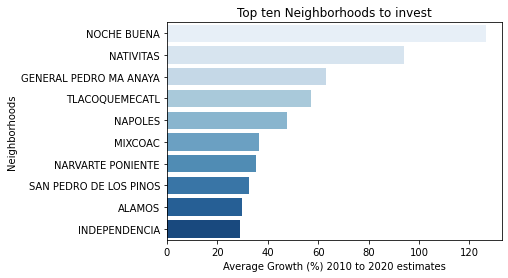

In [16]:
results_mean=results_mean.sort_values('growth',ascending=False).head(10)
ax = sns.barplot(x="growth", y="colonia_predio", data=results_mean,palette = 'Blues')
plt.title('Top ten Neighborhoods to invest')
plt.ylabel('Neighborhoods')
plt.xlabel('Average Growth (%) 2010 to 2020 estimates')
plt.show()

To plot the growth variable we have to set in zero the places were we didn't have information

In [17]:
bj_results['growth'][bj_results['growth'].isna()]=0

C:\Users\Wayssen\anaconda3\envs\pythonData\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Percentage $Price/m^2$ increase in 2010-2020 in Benito Juarez

<AxesSubplot:title={'center':'Price increase in Benito Juarez'}>

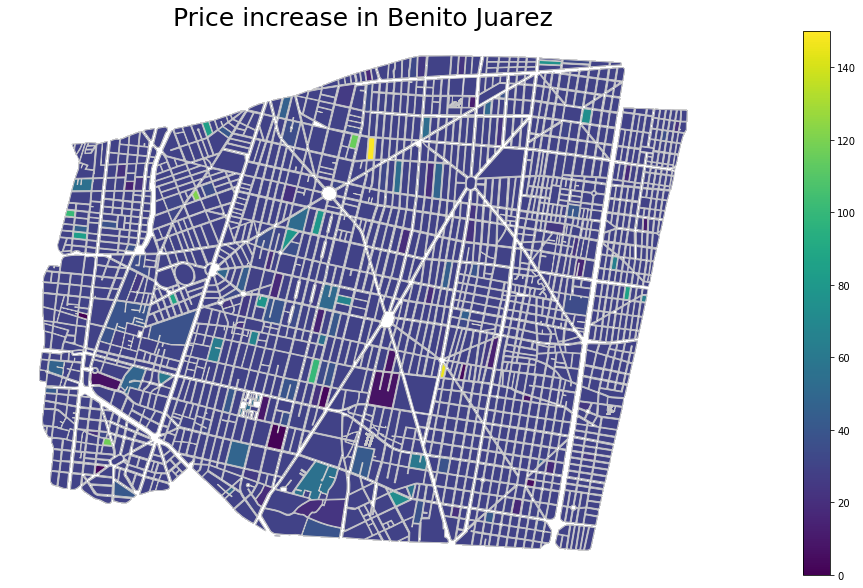

In [18]:
# set the value column that will be visualised
variable = 'growth'
# set the range for the choropleth values
vmin, vmax = 0, 150
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))
# remove the axis
ax.axis('off')
# add a title and annotation
ax.set_title('Price increase in Benito Juarez', fontdict={'fontsize': '25', 'fontweight' : '3'})
# ax.annotate('Source: Wikipedia - https://en.wikipedia.org/wiki/Provinces_of_Indonesia', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')
# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
fig.colorbar(sm)
# create map
bj_results.plot(column=variable, cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8')

## Create geojson from geopandas

In [35]:
# Copy dataframe
bj_simplify = bj_results.copy()

# Simplify geometry data
bj_simplify["geometry"] = bj_simplify["geometry"].simplify(tolerance=0.5, preserve_topology=True)

# Select only some of the columns
bj_simplify = bj_simplify[['geometry', 'growth', 'colonia_predio']]

# Export geometry to geojson format
bj_simplify.to_file("./flask/datasets/bj_simplifly.geojson", encoding='utf-8', driver='GeoJSON')